# Concept Bottleneck model concept recall accuracy

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

from policy import ConceptNet
from jem import data_utils

model_name = 'net'
session_name =  'falcon'
board_size = 5
nr_of_concepts = data_utils.get_number_of_concepts()

benchmark_model_path = "../models/cbm/net_1000.keras"

agents_to_sample = [100, 200, 300, 500, 700, 1000]
cases_to_sample = 1000

full_model_path = f"../models/cbm/"

def load_model(full_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    model = ConceptNet(board_size, load_path=model_path)
    return model

agents = [load_model(full_model_path, epoch) for epoch in agents_to_sample]

model = ConceptNet(board_size, nr_of_concepts, load_path=benchmark_model_path)

states, concepts = data_utils.generate_binary_concept_encodings(agents, cases_to_sample, board_size)

print(f'Generated datset containing {states.shape[0]} states and {concepts.shape[0]} concepts')

Generating binary encodings for board size 5


Generating concept datasets: 1156it [00:26, 44.36it/s]                         

Generated datset containing 1000 states and 1000 concepts


In [70]:
# Testing the accuracy of the concept bottleneck output
concepts_pred = model.predict_concepts(states)

32/32 [==============================] - 0s 7ms/step


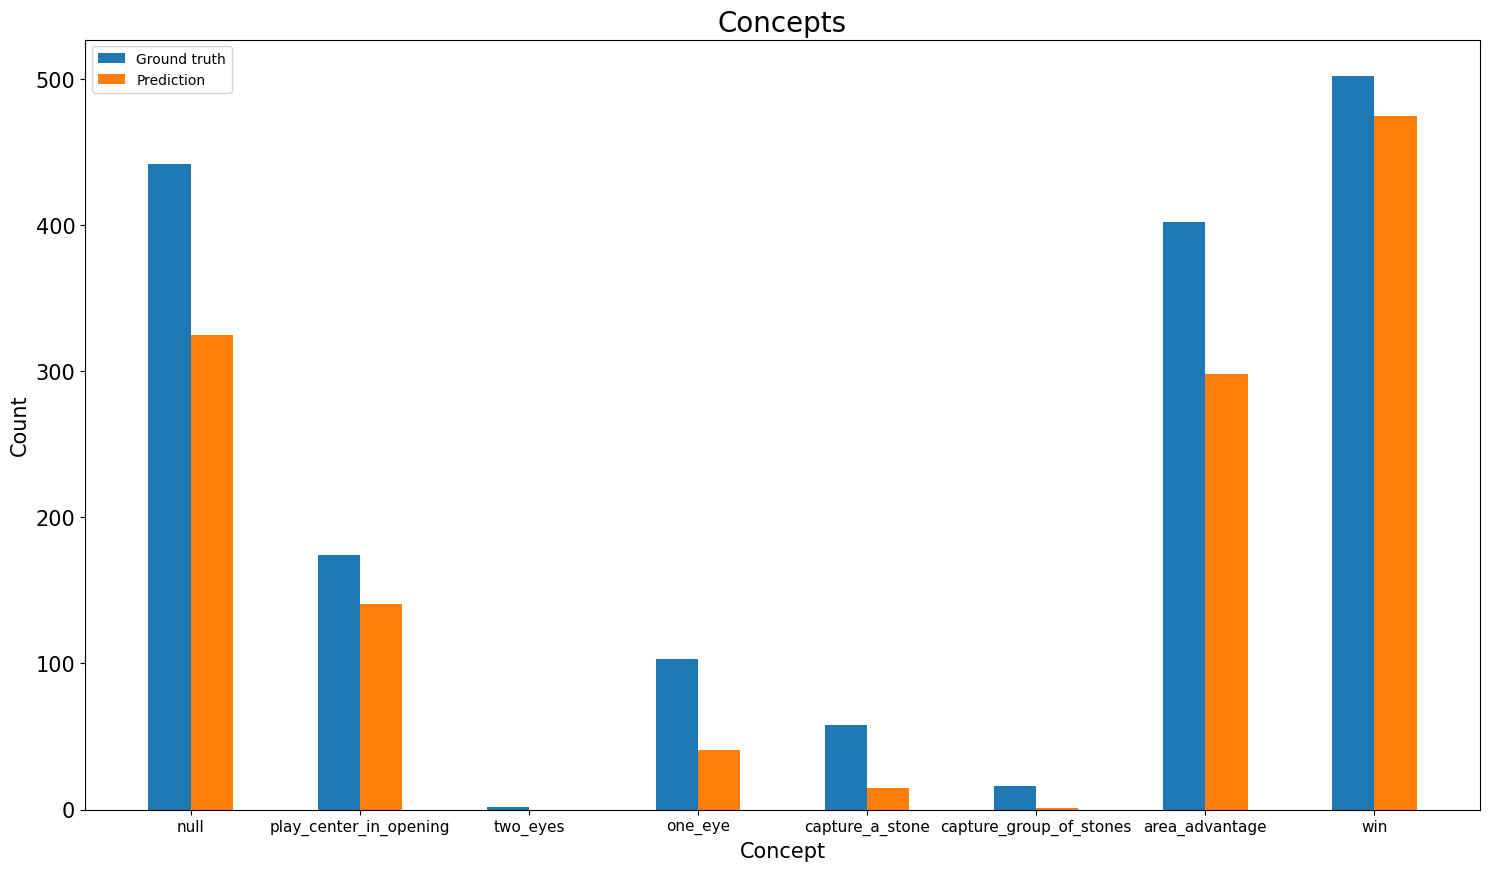

In [81]:
concepts_gt_dict = data_utils.concept_functions_to_dict()
concepts_pred_dict = data_utils.concept_functions_to_dict()

# Plot the accuracy of each individual concept in the bottleneck layer
for i, concept in enumerate(concepts):
    # Find the index with the highest value in the prediction
    pred = concepts_pred[i]
    
    # Find all the indices where the concept is 1
    for j in range(len(concept)):
        if concept[j] == 1:
            concept_name = data_utils.concept_idx_to_name(j)
            concepts_gt_dict[concept_name] += 1
    
    # Find the index of the 2 largest values in the prediction
    pred_indices = np.argpartition(pred, -3)[-3:]
    for idx in pred_indices:
        if concept[idx] == 1:
            concept_name = data_utils.concept_idx_to_name(idx)
            concepts_pred_dict[concept_name] += 1


# Plot the concepts_gt_dict and concepts_pred_dict
fig, ax = plt.subplots()
index = np.arange(len(concepts_gt_dict.keys()))
bar_width = 0.25

# Set the window size
fig.set_size_inches(18, 10)

rects1 = ax.bar(index, concepts_gt_dict.values(), bar_width, label='Ground truth')
rects2 = ax.bar(index + bar_width, concepts_pred_dict.values(), bar_width, label='Prediction')

ax.set_xlabel('Concept', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Concepts', fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(concepts_gt_dict.keys())

# Add this line to increase the font size of the x-ticks to 15
ax.tick_params(axis='x', labelsize=11)

# Add this line to increase the font size of the y-ticks to 15
ax.tick_params(axis='y', labelsize=15)
ax.legend()

plt.show()